In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
#Check number of prefectures in data
prefectures = pd.read_csv('prefecture_code.csv')
prefectures.head()

,Code,JpName,EnName
0,1,北海道,Hokkaido
1,2,青森県,Aomori
2,3,岩手県,Iwate
3,4,宮城県,Miyagi
4,5,秋田県,Akita


A total of 47 prefectures is in the trade_prices csv files, from this we're going to check the number of columns and what might be relevant

In [3]:
#Opening of one of the trade_prices csv file
df = pd.read_csv('trade_prices//01.csv')
df.head()

C:\Users\SKill\AppData\Local\Temp\ipykernel_3340\3728976929.py:2: DtypeWarning: Columns (12,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('trade_prices//01.csv')


,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28.0,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,NaN
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20.0,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,NaN
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26.0,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23.0,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,NaN


In [4]:
print(df.shape)
print(df.columns)

(186238, 38)
Index(['No', 'Type', 'Region', 'MunicipalityCode', 'Prefecture',
       'Municipality', 'DistrictName', 'NearestStation',
       'TimeToNearestStation', 'MinTimeToNearestStation',
       'MaxTimeToNearestStation', 'TradePrice', 'FloorPlan', 'Area',
       'AreaIsGreaterFlag', 'UnitPrice', 'PricePerTsubo', 'LandShape',
       'Frontage', 'FrontageIsGreaterFlag', 'TotalFloorArea',
       'TotalFloorAreaIsGreaterFlag', 'BuildingYear', 'PrewarBuilding',
       'Structure', 'Use', 'Purpose', 'Direction', 'Classification', 'Breadth',
       'CityPlanning', 'CoverageRatio', 'FloorAreaRatio', 'Period', 'Year',
       'Quarter', 'Renovation', 'Remarks'],
      dtype='object')


From this, it appears that the dataset contains 38 columns and 186238 entries. It can also be noted that the prefecture has not been edited to its prefecture code. All data would now then be loaded into a single pandas DataFrame

In [5]:
df.drop(df.index, inplace=True)
#Describing dtype in each of the column 
df = pd.concat((pd.read_csv(file, dtype={
    'No': 'int64',  'Type': 'category', 'Region': 'category', 'MunicipalityCode': 'category', 'Prefecture': 'category',
    'Municipality': 'category', 'DistrictName': 'category', 'NearestStation': 'category', 'TimeToNearestStation': 'string',
    'MinTimeToNearestStation': 'string', 'MaxTimeToNearestStation': 'string', 'TradePrice': 'float', 'FloorPlan': 'category',
    'Area': 'float', 'AreaIsGreaterFlag': 'bool', 'UnitPrice': 'float', 'PricePerTsubo': 'float', 'LandShape': 'category',
    'Frontage': 'float', 'FrontageIsGreaterFlag': 'bool', 'TotalFloorArea': 'float', 'TotalFloorAreaIsGreaterFlag': 'float',
    'BuildingYear': 'float', 'PrewarBuilding': 'bool', 'Structure': 'category', 'Use': 'category', 'Purpose': 'category',
    'Direction': 'category', 'Classification': 'category', 'Breadth': 'float', 'CityPlanning': 'category',
    'CoverageRatio': 'float', 'FloorAreaRatio': 'float', 'Period': 'category', 'Year': 'int64', 'Quarter': 'int64',
    'Renovation': 'category', 'Remarks': 'string'
}) for file in glob('trade_prices/*.csv')), ignore_index=True)

In [6]:
df.head()

,No,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,MinTimeToNearestStation,...,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Year,Quarter,Renovation,Remarks
0,1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,...,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
1,2,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,4th quarter 2018,2018,4,NaN,<NA>
2,3,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,...,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,4th quarter 2018,2018,4,Not yet,<NA>
3,4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,...,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>
4,5,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,...,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2nd quarter 2018,2018,2,NaN,<NA>


From the following columns, the column 'No' can be omitted from the dataset as it would have no purpose on the prediction of real estate prices

As TimeToNearestStation and MinTime and MaxTime ToNearestStation is related to each other where TimeToNearestStation would be a string in which it describes the time range when one could reach the nearest station, this column is also omitted

As the 'Period' Column only pertains to the 'Quarter' Columns, this column can also be removed

The 'Remarks' Column is rarely used, this column is also removed from the dataset.

# Removal of Initial Data & Null Values

In [7]:
df.drop(columns=['No','TimeToNearestStation', 'Period', 'Remarks'], inplace=True)
df.head()

,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,...,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter,Renovation
0,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,...,Other,South,City Road,10.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
1,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,...,House,East,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4,NaN
2,"Pre-owned Condominiums, etc.",NaN,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,...,House,NaN,NaN,NaN,Neighborhood Commercial Zone,80.0,200.0,2018,4,Not yet
3,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,...,NaN,West,Private Road,4.0,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN
4,Residential Land(Land Only),Residential Area,1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,...,House,West,City Road,7.2,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2,NaN


In [8]:
#Shows number of missing data in each of the column
print(df.isnull().sum())
print(df.shape)

Type                                 0
Region                         1117077
MunicipalityCode                     0
Prefecture                           0
Municipality                         0
DistrictName                      8275
NearestStation                  565811
MinTimeToNearestStation         590541
MaxTimeToNearestStation         678447
TradePrice                           0
FloorPlan                      3309348
Area                                 0
AreaIsGreaterFlag                    0
UnitPrice                      2522103
PricePerTsubo                  2522103
LandShape                      1127530
Frontage                       1369455
FrontageIsGreaterFlag                0
TotalFloorArea                 2588858
TotalFloorAreaIsGreaterFlag          0
BuildingYear                   2036714
PrewarBuilding                       0
Structure                      1993945
Use                            2020044
Purpose                        2723740
Direction                

Columns in which more than 1 million records of data is missing would be omitted, the following columns are:
- Floor Plan
- Structure
- Use
- Purpose
- Renovation
- Region
- Unit Price
- PricePerTsubo
- LandShape
- Frontage
- TotalFloorArea
- BuildingYear
- Structure
- Use
- Purpose
- Direction
- Classification
- Breadth

In [9]:
df.drop(columns=['FloorPlan','Structure', 'Use', 'Purpose', 'Renovation', 'Region' ,'UnitPrice',
                'PricePerTsubo', 'LandShape', 'Frontage', 'TotalFloorArea','BuildingYear','Structure','Use',
                'Purpose','Direction','Classification','Breadth'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,28,28,86000000.0,1100.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,27,27,38000000.0,310.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,20,20,19000000.0,95.0,False,False,0.0,False,Neighborhood Commercial Zone,80.0,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,26,26,5000000.0,290.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",Asahigaoka,Maruyamakoen,23,23,25000000.0,430.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,2


In [10]:
print(df.isnull().sum())
print(df.shape)

Type                                0
MunicipalityCode                    0
Prefecture                          0
Municipality                        0
DistrictName                     8275
NearestStation                 565811
MinTimeToNearestStation        590541
MaxTimeToNearestStation        678447
TradePrice                          0
Area                                0
AreaIsGreaterFlag                   0
FrontageIsGreaterFlag               0
TotalFloorAreaIsGreaterFlag         0
PrewarBuilding                      0
CityPlanning                   530666
CoverageRatio                  714641
FloorAreaRatio                 714641
Year                                0
Quarter                             0
dtype: int64
(3906518, 19)


The remaining data that have null values would be removed from the dataset

In [11]:
df = df.dropna()
print(df.isnull().sum())
print(df.shape)

Type                           0
MunicipalityCode               0
Prefecture                     0
Municipality                   0
DistrictName                   0
NearestStation                 0
MinTimeToNearestStation        0
MaxTimeToNearestStation        0
TradePrice                     0
Area                           0
AreaIsGreaterFlag              0
FrontageIsGreaterFlag          0
TotalFloorAreaIsGreaterFlag    0
PrewarBuilding                 0
CityPlanning                   0
CoverageRatio                  0
FloorAreaRatio                 0
Year                           0
Quarter                        0
dtype: int64
(3077722, 19)


From this, it appears that approximately 3.07 million records would be used for the training and testing of the dataset.

The model would be attempting to predict the TradePrice column based on the values of the other columns.

# Removing subset column and unneeded column

Moving onto the *DistrictName* column, as this column is only based from the Municipality itself, where-in the District is a location within a Municipality, further dividing each Municipality to districts would further diversify the data. This column would then be omitted

Furthermore, the column *NearestStation* could also be removed as it only describes what the name of the Station that is nearest to the location, the columns *MinTimeToNearestStation* and *MaxTimeToNearestStation* could have more valuable data compared to the column *NearestStation*.

In [12]:
df.drop(columns=['DistrictName', 'NearestStation'], inplace = True)

In [13]:
df.head(2)

,Type,MunicipalityCode,Prefecture,Municipality,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,CoverageRatio,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",28,28,86000000.0,1100.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",27,27,38000000.0,310.0,False,False,0.0,False,Category I Exclusively Low-story Residential Zone,40.0,80.0,2018,4


# Conversion of other types to integer

As these columns besides the *PrewarBuilding* column had null values beforehand, they couldn't be converted to integers. These columns would now be converted as such. FrontageIsGreaterFlag (boolean), PrewarBuilding (boolean). For both of the boolean columns, these would be converted to a binary integer of 0s and 1s.

The columns *PrewarBuilding* and *FrontageIsGreaterFlag* would be converted from a boolean string to an integer of 0s and 1s. 

Whilst the columns MinTimeToNearestStation and MaxTimeToNearestStation would now be converted to an integer as the null values have already been removed

In [14]:
df['FrontageIsGreaterFlag'] = df['FrontageIsGreaterFlag'].astype(int)
df['PrewarBuilding'] = df['PrewarBuilding'].astype(int)
df['MinTimeToNearestStation'] = df['MinTimeToNearestStation'].astype(int)
df['MaxTimeToNearestStation'] = df['MaxTimeToNearestStation'].astype(int)

# Checking for Correlated Columns

In [15]:
#Know correlation between data, data that has a correlation value of more than 0.5 would have one of the columns be omitted
df.corr()

,MinTimeToNearestStation,MaxTimeToNearestStation,TradePrice,Area,AreaIsGreaterFlag,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CoverageRatio,FloorAreaRatio,Year,Quarter
MinTimeToNearestStation,1.000000,0.946280,-0.055172,0.203385,0.081312,0.074873,-0.005360,-0.003139,-0.224305,-0.266145,-0.006659,0.010205
MaxTimeToNearestStation,0.946280,1.000000,-0.052610,0.208283,0.084485,0.077275,-0.003406,-0.002981,-0.204856,-0.244897,-0.007465,0.010174
TradePrice,-0.055172,-0.052610,1.000000,0.183885,0.181598,0.136064,0.288844,0.000520,0.041112,0.082946,-0.012940,-0.007162
Area,0.203385,0.208283,0.183885,1.000000,0.681670,0.463064,0.197990,0.000736,-0.055481,-0.099257,0.014769,0.000479
AreaIsGreaterFlag,0.081312,0.084485,0.181598,0.681670,1.000000,0.492015,0.204042,0.000681,-0.000987,-0.013673,0.002282,-0.005017
FrontageIsGreaterFlag,0.074873,0.077275,0.136064,0.463064,0.492015,1.000000,0.151547,-0.000056,0.001691,-0.013214,0.001489,-0.004655
TotalFloorAreaIsGreaterFlag,-0.005360,-0.003406,0.288844,0.197990,0.204042,0.151547,1.000000,0.003126,0.040546,0.056547,-0.003814,-0.004928
PrewarBuilding,-0.003139,-0.002981,0.000520,0.000736,0.000681,-0.000056,0.003126,1.000000,0.011964,0.008831,-0.000389,0.000735
CoverageRatio,-0.224305,-0.204856,0.041112,-0.055481,-0.000987,0.001691,0.040546,0.011964,1.000000,0.790854,0.022179,-0.004675
FloorAreaRatio,-0.266145,-0.244897,0.082946,-0.099257,-0.013673,-0.013214,0.056547,0.008831,0.790854,1.000000,0.016625,-0.006931


From the data given above, the columns
- Area : AreaIsGreaterFlag
- FloorAreaRatio : CoverageRatio
- MinTimeToNearestStation : MaxTimeToNearestStation

Are moderately to highly correlated, thus AreaIsGreaterFlag, CoverageRatio, and MaxTimeToNearestStation columns would be dropped from the dataset

In [16]:
df.drop(columns=['AreaIsGreaterFlag', 'CoverageRatio', 'MaxTimeToNearestStation'], inplace=True)
df.head()

,Type,MunicipalityCode,Prefecture,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter
0,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",28,86000000.0,1100.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4
1,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",27,38000000.0,310.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4
2,"Pre-owned Condominiums, etc.",1101,Hokkaido,"Chuo Ward,Sapporo City",20,19000000.0,95.0,0,0.0,0,Neighborhood Commercial Zone,200.0,2018,4
3,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",26,5000000.0,290.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,2
4,Residential Land(Land Only),1101,Hokkaido,"Chuo Ward,Sapporo City",23,25000000.0,430.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,2


In [17]:
df['TradePrice'].describe()

count    3.077722e+06
mean     3.289767e+07
std      1.554923e+08
min      1.000000e+02
25%      8.500000e+06
50%      1.800000e+07
75%      3.300000e+07
max      6.100000e+10
Name: TradePrice, dtype: float64

# Temporary Column of TradePrice

As the TradePrice value ranges from 100 Yen all the way to 61 billion yen with an average of around 3 million per yen. A new column would be added temporarily with the value of 1 per Million Yen

In [18]:
df['TPMil'] = df['TradePrice'].div(1000000)

# Knowing relationship between Prefectures and TradePrice

It appears that the dataset is right-skewed with the outliers removed. From this dataset, other columns would also be analyzed

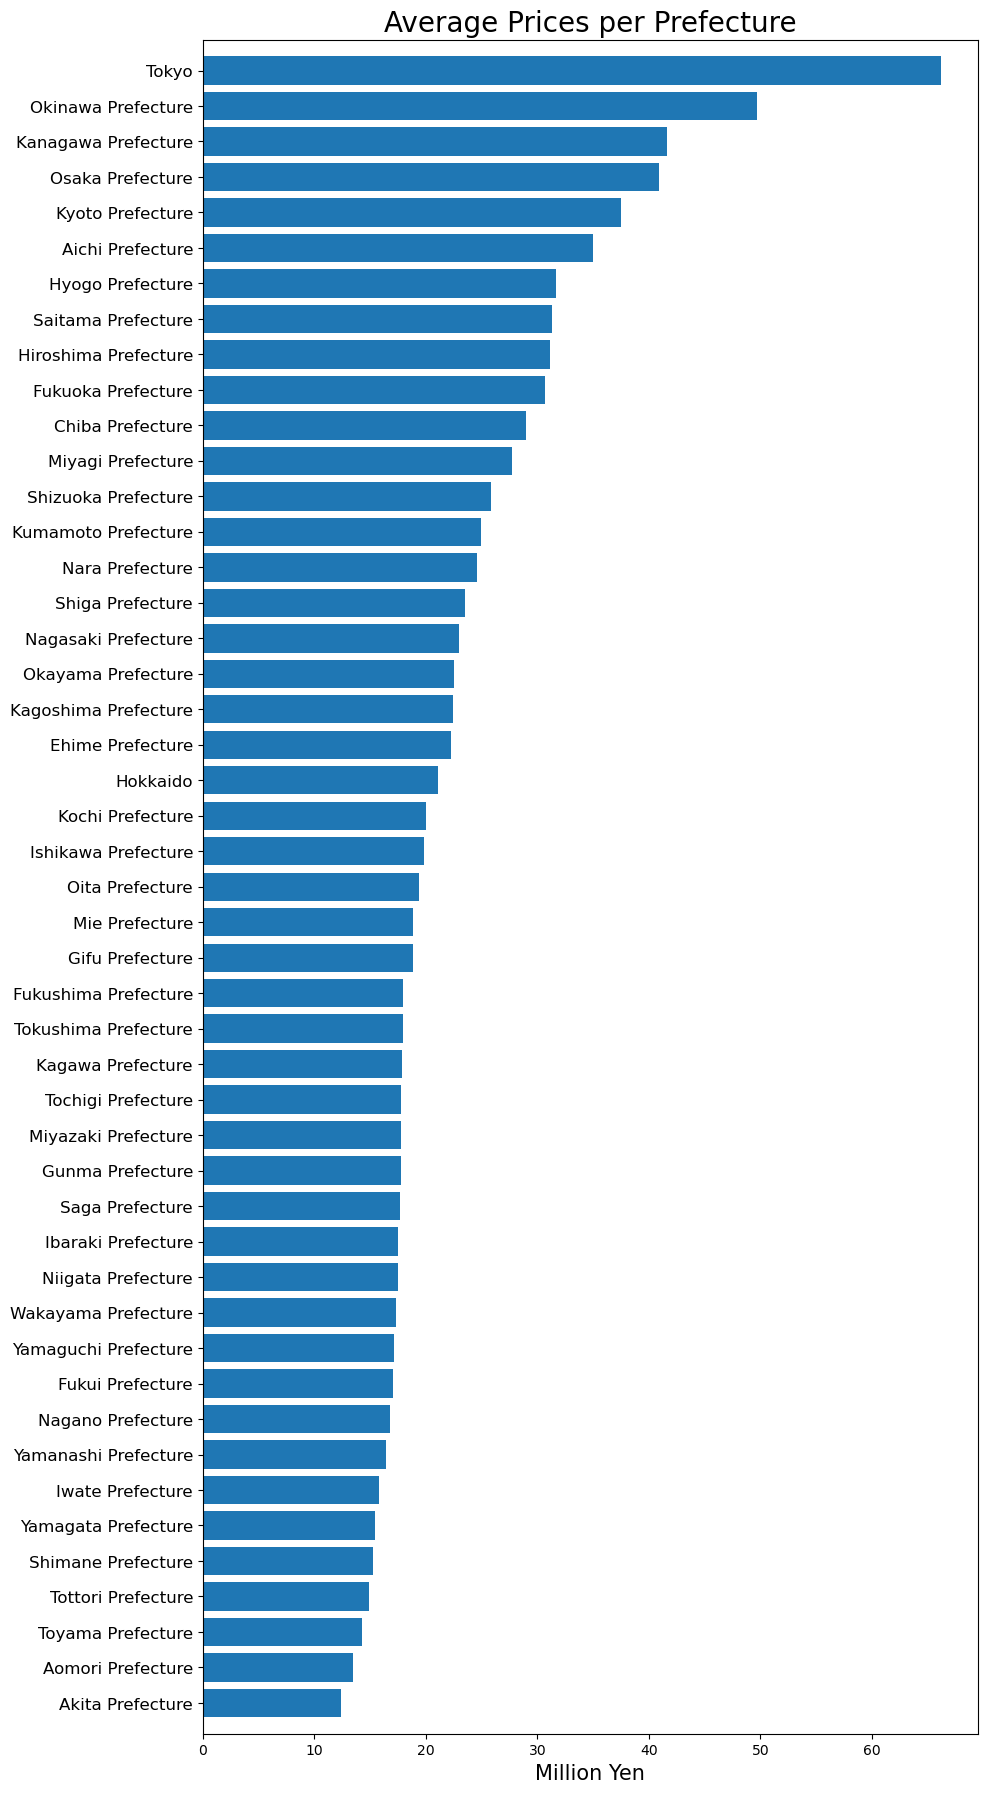

In [19]:
prefectureTP = df.groupby('Prefecture', as_index = False)['TPMil'].mean().sort_values('TPMil', ascending=False)
fig, ax = plt.subplots(figsize=(10,22))
ax.barh(prefectureTP['Prefecture'], prefectureTP['TPMil'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title('Average Prices per Prefecture', fontsize=20)
plt.yticks(fontsize=12)
plt.savefig('AveragePricesPerPrefecture.png', dpi=300, bbox_inches='tight')
plt.show()

From the horizontal bar graph given, it appears that one of the driving factors for the price of a property is the location of the property itself. For further analysis, the different municipalities per prefecture would be compared if it also affects the mean price of a location

A comparison between the average prices per Municipality would be compared know if location within a certain prefecture affects the price by a significant amount

In [20]:
for i, row in prefectureTP.iterrows():
    MuniTP = df.loc[df['Prefecture'] == row['Prefecture']].groupby('Municipality', 
                                                              as_index = False).mean().sort_values('TPMil', ascending = False)
    prefectureTP.loc[prefectureTP['Prefecture'] == row['Prefecture'], 'min'] = MuniTP.min()['TPMil']
    prefectureTP.loc[prefectureTP['Prefecture'] == row['Prefecture'], 'max'] = MuniTP.max()['TPMil']

In [21]:
prefectureTP

,Prefecture,TPMil,min,max
40,Tokyo,66.172134,24.848692,221.916405
31,Okinawa Prefecture,49.719548,11.000000,49.920791
18,Kanagawa Prefecture,41.626207,8.500000,71.456711
32,Osaka Prefecture,40.865680,5.825875,127.126990
21,Kyoto Prefecture,37.464062,5.147793,71.653346
0,Aichi Prefecture,34.990038,9.668542,113.761463
12,Hyogo Prefecture,31.703557,1.800000,57.593638
34,Saitama Prefecture,31.276515,3.700000,72.250186
10,Hiroshima Prefecture,31.121151,10.673977,75.134997
6,Fukuoka Prefecture,30.711828,4.132283,62.944853


With the table where the minimum and maximum is shown from the table, where the average prices of a prefecture can be widely different to the average prices of a municipality, the column *prefecture* would be dropped.

In [22]:
df.drop(columns=['Prefecture', 'MunicipalityCode'], inplace= True)
df.head(2)

,Type,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter,TPMil
0,Residential Land(Land Only),"Chuo Ward,Sapporo City",28,86000000.0,1100.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4,86.0
1,Residential Land(Land Only),"Chuo Ward,Sapporo City",27,38000000.0,310.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4,38.0


# Removal of Insufficient Data

To further process the data, municipalities with only count of less than 100 will be removed.

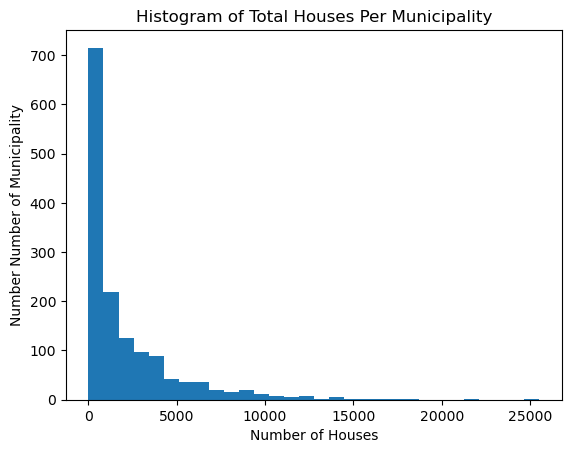

In [23]:
numMunicipality = df['Municipality'].value_counts(dropna=True, sort=True)
plt.hist(numMunicipality.values, bins=30)
plt.title("Histogram of Total Houses Per Municipality")
plt.xlabel("Number of Houses")
plt.ylabel("Number Number of Municipality")
plt.savefig('HistogramHousePerMuni.png', dpi=300, bbox_inches='tight')
plt.show()

In [24]:
for mncplt in numMunicipality.keys():
    if numMunicipality[mncplt] < 100:
        df.drop(df[df['Municipality'] == mncplt].index, inplace=True)
df.shape

(3071107, 13)

In [25]:
df['TPMil'].describe()

count    3.071107e+06
mean     3.294893e+01
std      1.556471e+02
min      1.000000e-04
25%      8.500000e+00
50%      1.800000e+01
75%      3.300000e+01
max      6.100000e+04
Name: TPMil, dtype: float64

With the given data, it seems that the mean and standard deviation is way too differentiated with 155 million Yen as standard deviation whereas the mean is only around 33 million yen. Any values above the first range in getPriceRange would be removed.

# Removing High Outliers in the Dataset with a Histogram

In [26]:
#Evenly cut the range from the min of TradePrice to max of TradePrice to a specific number of bins
def getPriceRange(numbins, filename):
    TPV = df['TPMil'].value_counts(bins = numbins)
    ax = TPV.plot.bar(figsize=(15,5))
    ax.margins(y=0.01)
    ax.set_xlabel('House Prices (Million)', fontsize = 15)
    ax.set_ylabel('Number of Houses', fontsize = 15)
    ax.set_title(f'Price Range', fontsize=20)
    plt.yticks(fontsize=12)
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    plt.show()
    del ax, TPV

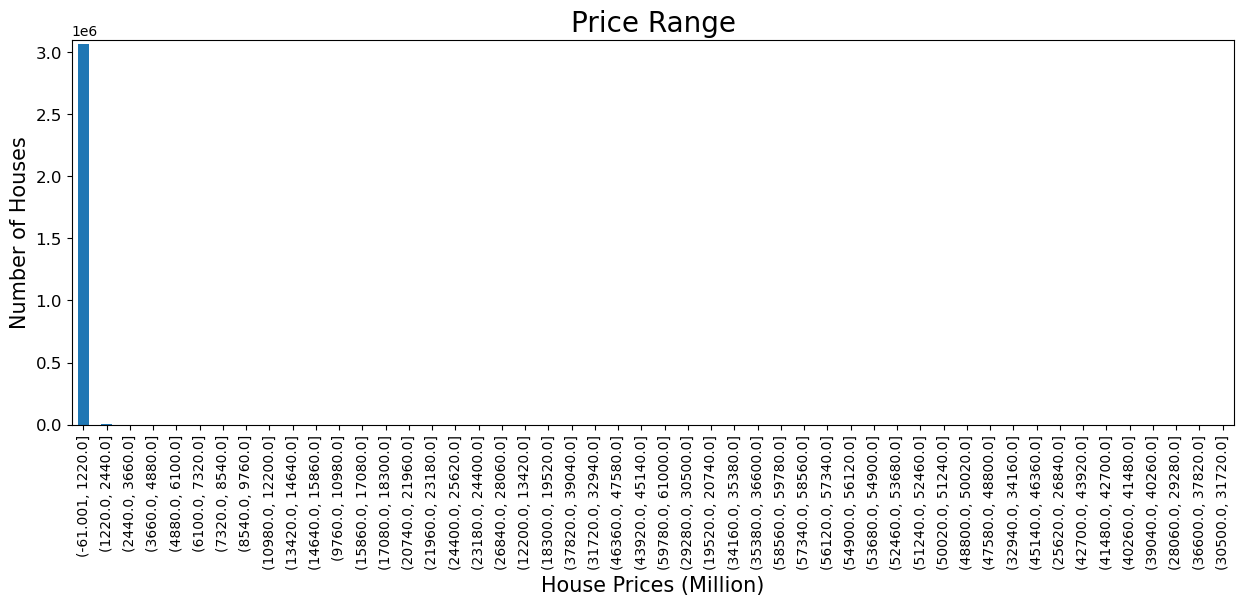

In [27]:
getPriceRange(50, "HistogramHouse1")

In [28]:
print("Number of Houses Above 12 Billion Yen: ", df.loc[df['TPMil'] > 1220].shape)
print("Total Number of Houses: ", df.shape)

Number of Houses Above 12 Billion Yen:  (3456, 13)
Total Number of Houses:  (3071107, 13)


From this, it appears that less than 0.11% is above 1.2 Billion Yen, these data would then be omitted

In [29]:
df = df.loc[df['TPMil'] < 1220]

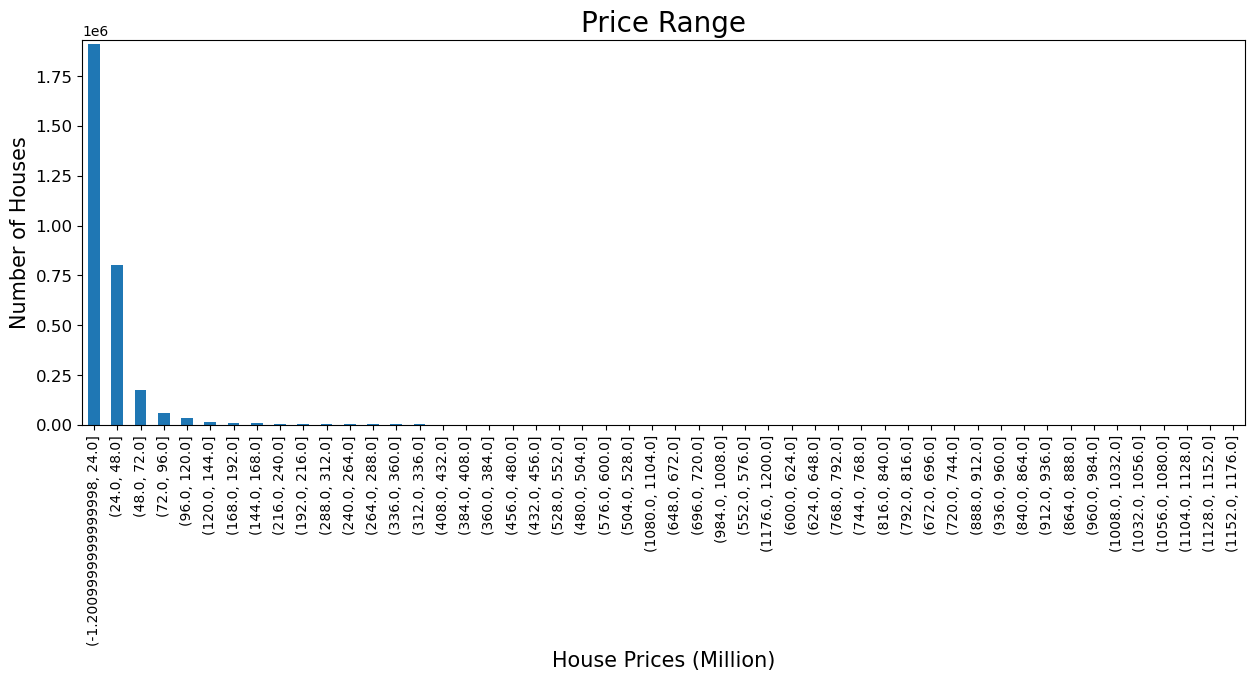

In [30]:
getPriceRange(50, 'HistogramHouse2')

In [31]:
print("Number of Houses Above 120 Million Yen: ", df.loc[df['TPMil'] > 120].shape)
print("Total Number of Houses: ", df.shape)

Number of Houses Above 120 Million Yen:  (83073, 13)
Total Number of Houses:  (3067651, 13)


From this, it appears that less than 2.7% is above 120 Million Yen, these data would then be omitted

In [32]:
df = df.loc[df['TPMil'] < 120]

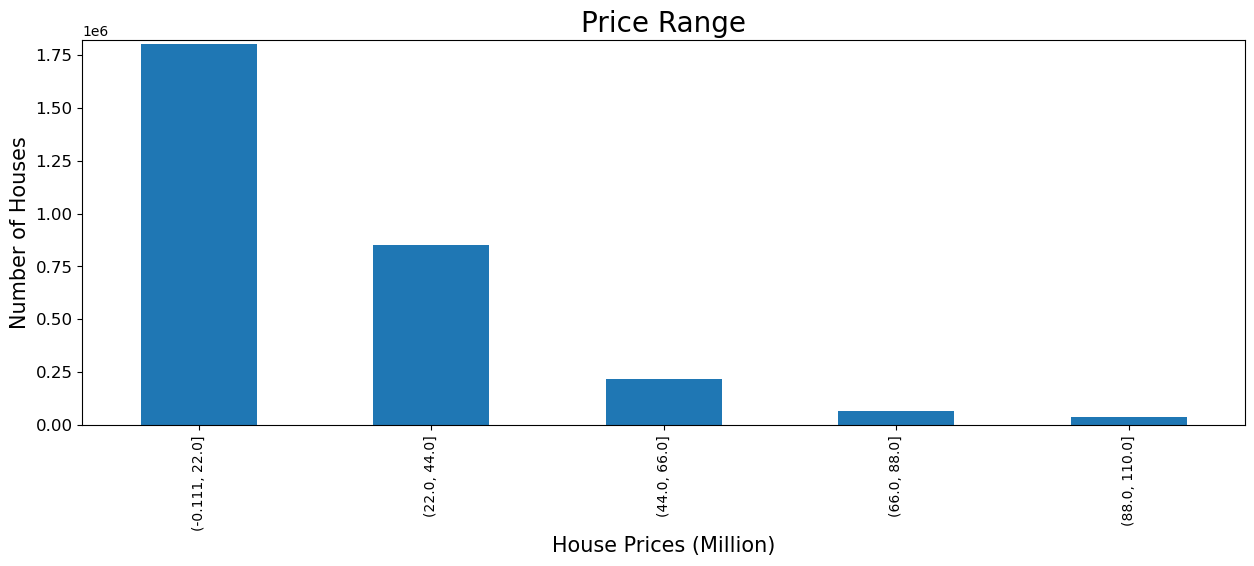

In [33]:
getPriceRange(5, 'HistogramHouse3')

In [34]:
print("Number of Houses Above 66 Million Yen: ", df.loc[df['TPMil'] > 66].shape)
print("Total Number of Houses: ", df.shape)

Number of Houses Above 66 Million Yen:  (107178, 13)
Total Number of Houses:  (2974678, 13)


From this, it appears that less than 3.6% is above 120 Million Yen, these data would then be omitted

As more than 5% (6.30% in total) of the data has been erased from the dataset, we can now conclude that the outliers have been mostly removed.

# Removal of Low Outliers with Statistical Analysis

In [35]:
df['TPMil'].quantile(q=0.05)

2.2

Houses sold less than 2.2 million would also be removed from the dataset to remove the low outliers

In [36]:
df = df.loc[df['TPMil'] > 2.2]

# Checking relationship between TradePrice and Type

Moving to the *Type* column, there are three known categories. The average prices of each category would now be computed to see if there is a significant difference between the prices of these properties

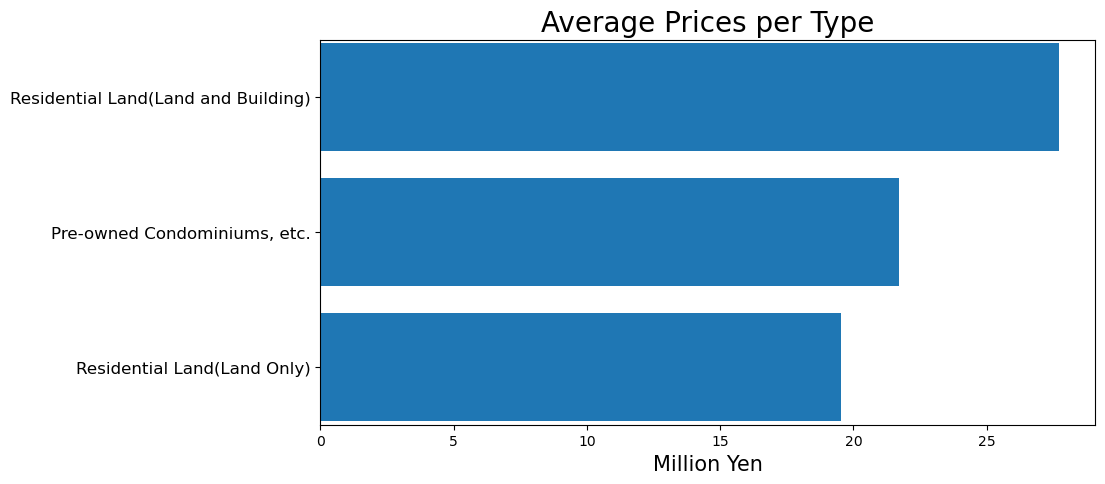

In [37]:
propertyType = df.groupby('Type', as_index = False).mean().sort_values('TPMil', ascending = False)

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(propertyType['Type'], propertyType['TPMil'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per Type', fontsize=20)
plt.yticks(fontsize=12)
plt.savefig("AveragePricePerType.png", dpi=300, bbox_inches = 'tight')
plt.show()

From the following, the type variable could prove useful in determining the price of a property, thus the *type* column would be hot-encoded as to make it easier for the model to use the data

In [38]:
TypeEncode = pd.get_dummies(df['Type'])
df = df.join(TypeEncode)
df.drop(columns=['Type', 'Forest Land', 'Agricultural Land'], inplace=True)
del TypeEncode

In [39]:
df.head(2)

,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,CityPlanning,FloorAreaRatio,Year,Quarter,TPMil,"Pre-owned Condominiums, etc.",Residential Land(Land Only),Residential Land(Land and Building)
0,"Chuo Ward,Sapporo City",28,86000000.0,1100.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4,86.0,0,1,0
1,"Chuo Ward,Sapporo City",27,38000000.0,310.0,0,0.0,0,Category I Exclusively Low-story Residential Zone,80.0,2018,4,38.0,0,1,0


# Hot-encoding of CityPlanning and Mean-encoding of Municipality

The number of unique values for the column *CityPlanning* is 16, the TradePrice mean of these unique values would be taken as to see if different CityPlanning categories can affect the price of a certain property.

In [40]:
len(df['CityPlanning'].unique())

16

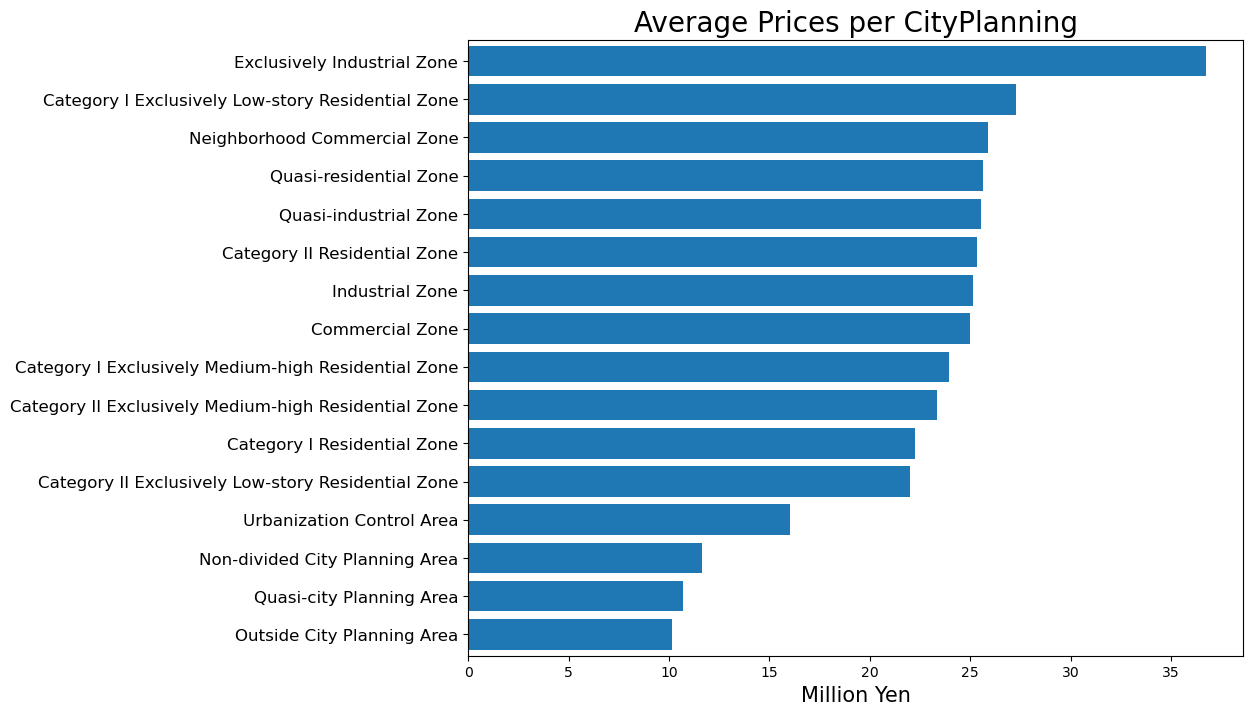

In [41]:
CityPlanningPrice = df.groupby('CityPlanning', as_index = False).mean().sort_values('TPMil', ascending = False)

fig, ax = plt.subplots(figsize=(10,8))
ax.barh(CityPlanningPrice['CityPlanning'], CityPlanningPrice['TPMil'])
ax.invert_yaxis()
ax.margins(y=0.01)
ax.set_xlabel('Million Yen', fontsize = 15)
ax.set_title(f'Average Prices per CityPlanning', fontsize=20)
plt.yticks(fontsize=12)
plt.savefig("AveragePriceperCP.png", dpi=300, bbox_inches = 'tight')
plt.show()

In [42]:
CityPlanningPrice[['CityPlanning','TPMil']]

,CityPlanning,TPMil
7,Exclusively Industrial Zone,36.743805
0,Category I Exclusively Low-story Residential Zone,27.271329
9,Neighborhood Commercial Zone,25.903981
14,Quasi-residential Zone,25.624286
13,Quasi-industrial Zone,25.539599
5,Category II Residential Zone,25.316498
8,Industrial Zone,25.125495
6,Commercial Zone,25.002406
1,Category I Exclusively Medium-high Residential...,23.919130
4,Category II Exclusively Medium-high Residentia...,23.352235


In [43]:
del CityPlanningPrice

From the following table and graph, it appears that the Trade Price can also widely vary depending on the category of the estate in CityPlanning. However, as some categories are near to prices to each other where-in they are in the same millionth number, these categories could be combined. From 16 categories, 7 categories would be left for CityPlanning

The remaining categories would then be hot-encoded

In [44]:
#Grouping of categories
df['CityPlanning'] = df['CityPlanning'].replace(['Neighborhood Commercial Zone',
                                                 'Quasi-residential Zone',
                                                'Quasi-industrial Zone',
                                                'Category II Residential Zone',
                                                'Industrial Zone',
                                                'Commercial Zone'], 'CP Combined I')

df['CityPlanning'] = df['CityPlanning'].replace(['Category I Exclusively Medium-high Residential Zone',
                                                 'Category II Exclusively Medium-high Residential Zone'], 'CP Combined II')

df['CityPlanning'] = df['CityPlanning'].replace(['Category I Residential Zone',
                                                'Category II Exclusively Low-story Residential Zone'], 'CP Combined III')

df['CityPlanning'] = df['CityPlanning'].replace(['Quasi-city Planning Area',
                                                'Outside City Planning Area'], 'CP Combined IV')


In [45]:
#Hot-encoding of CityPlanning Column
CityPlanningEncode = pd.get_dummies(df['CityPlanning'])
df = df.join(CityPlanningEncode)
df.drop(columns=['CityPlanning'], inplace=True)
del CityPlanningEncode

In [46]:
df.columns

Index(['Municipality', 'MinTimeToNearestStation', 'TradePrice', 'Area',
       'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag',
       'PrewarBuilding', 'FloorAreaRatio', 'Year', 'Quarter', 'TPMil',
       'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)',
       'Residential Land(Land and Building)', 'CP Combined I',
       'CP Combined II', 'CP Combined III', 'CP Combined IV',
       'Category I Exclusively Low-story Residential Zone',
       'Exclusively Industrial Zone', 'Non-divided City Planning Area',
       'Urbanization Control Area'],
      dtype='object')

In [47]:
df.head(2)

,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,Quarter,...,Residential Land(Land Only),Residential Land(Land and Building),CP Combined I,CP Combined II,CP Combined III,CP Combined IV,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Non-divided City Planning Area,Urbanization Control Area
0,"Chuo Ward,Sapporo City",28,86000000.0,1100.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0
1,"Chuo Ward,Sapporo City",27,38000000.0,310.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0


# Conversion of TradePrice to log10

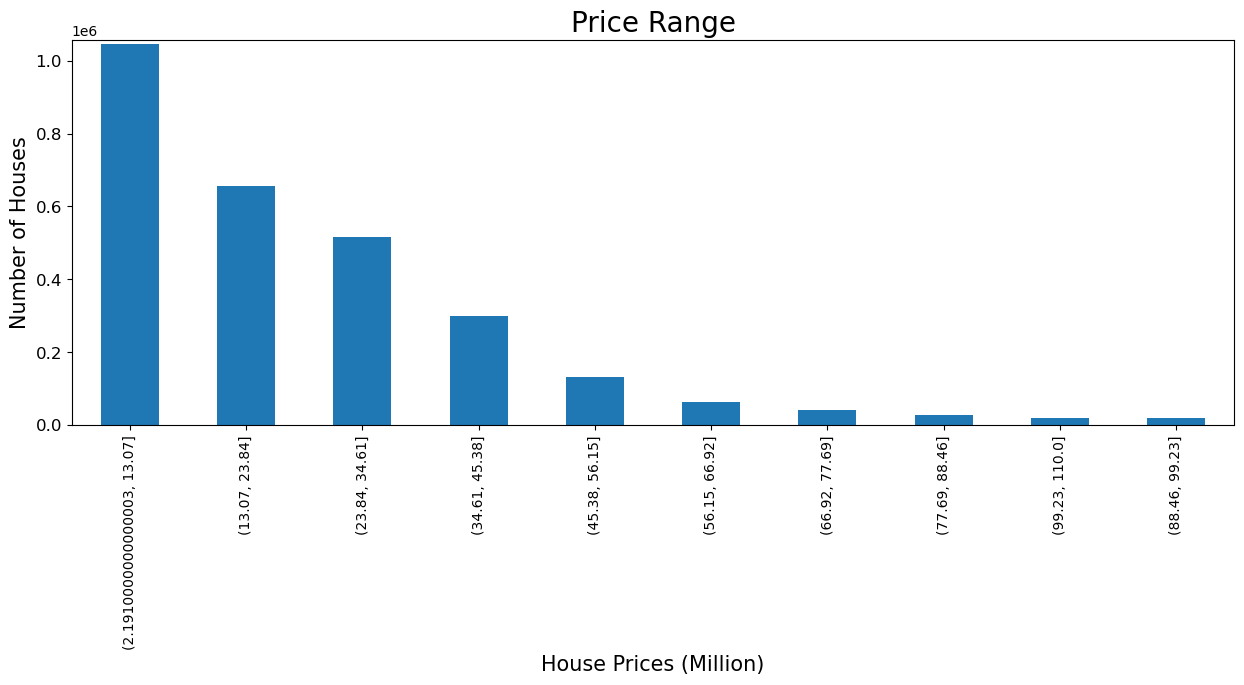

In [48]:
getPriceRange(10, 'HistogramHouse4')

As the trade price is heavily right skewed, TradePrice would be converted to log2 as to normalize the data, additionally the TPMil column would be removed as it is not needed anymore for further analysis

In [49]:
#Conversion of Yen to Million Yen
df['TradePrice'] = np.log10(df['TradePrice'])
df.drop(columns=['TPMil'], inplace=True)

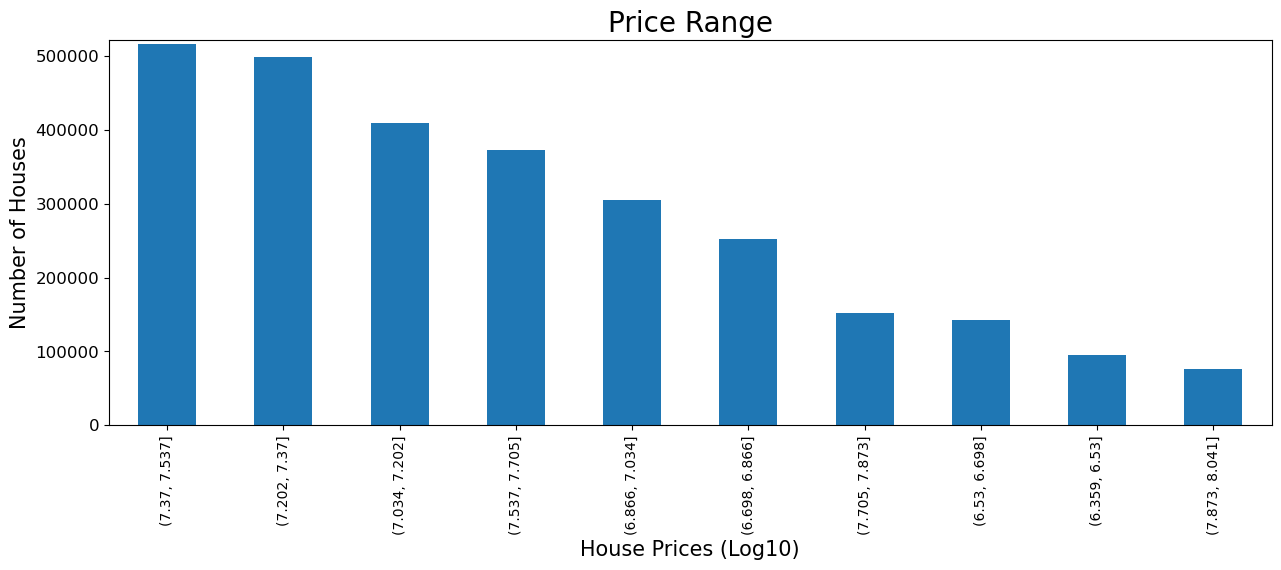

In [50]:
TPV = df['TradePrice'].value_counts(bins = 10)
ax = TPV.plot.bar(figsize=(15,5))
ax.margins(y=0.01)
ax.set_xlabel('House Prices (Log10)', fontsize = 15)
ax.set_ylabel('Number of Houses', fontsize = 15)
ax.set_title(f'Price Range', fontsize=20)
plt.yticks(fontsize=12)
plt.savefig(f"HistogramLog10.png", dpi=300, bbox_inches='tight')
plt.show()
del ax, TPV

In [50]:
df['TradePrice'].describe()

count    2.821915e+06
mean     7.233774e+00
std      3.605246e-01
min      6.361728e+00
25%      6.977724e+00
50%      7.278754e+00
75%      7.505150e+00
max      8.041393e+00
Name: TradePrice, dtype: float64

In [51]:
df.head(2)

,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,Quarter,...,Residential Land(Land Only),Residential Land(Land and Building),CP Combined I,CP Combined II,CP Combined III,CP Combined IV,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Non-divided City Planning Area,Urbanization Control Area
0,"Chuo Ward,Sapporo City",28,7.934498,1100.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0
1,"Chuo Ward,Sapporo City",27,7.579784,310.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0


From this, it appears that the only column that is not numerical is the Municipality (Categorical)

Additionally, as the MinTime and MaxTime ToNearestStation column was initially set into 'string' as there were null values, these columns would also be transformed into an integer as to fit into the model

In [52]:
MuniMean = df.groupby(['Municipality'])['TradePrice'].mean().to_dict()
df['Municipality'] = df['Municipality'].map(MuniMean)
del MuniMean

In [53]:
df.head(2)

,Municipality,MinTimeToNearestStation,TradePrice,Area,FrontageIsGreaterFlag,TotalFloorAreaIsGreaterFlag,PrewarBuilding,FloorAreaRatio,Year,Quarter,...,Residential Land(Land Only),Residential Land(Land and Building),CP Combined I,CP Combined II,CP Combined III,CP Combined IV,Category I Exclusively Low-story Residential Zone,Exclusively Industrial Zone,Non-divided City Planning Area,Urbanization Control Area
0,7.244443,28,7.934498,1100.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0
1,7.244443,27,7.579784,310.0,0,0.0,0,80.0,2018,4,...,1,0,0,0,0,0,1,0,0,0


# Model Creation and Testing

Now that all of the columns are numerical, the data would now be split into two a training set and a test set. Additionally, the TradePrice column would be removed from the table and be put onto another table.

The model used would be a XGBoost

In [54]:
x = df.copy()
y = x['TradePrice']
x.drop(columns=['TradePrice', 'Quarter'], inplace=True)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 30, stratify=x['Municipality'])
x_train = np.asarray(x_train).tolist()
y_train = np.asarray(y_train).tolist()
x_test = np.asarray(x_test).tolist()
y_test = np.asarray(y_test).tolist()

#Conversion of Actual and Predicted Values back to its original values
y_testActual = np.power(10, y_test)

In [55]:
x.columns

Index(['Municipality', 'MinTimeToNearestStation', 'Area',
       'FrontageIsGreaterFlag', 'TotalFloorAreaIsGreaterFlag',
       'PrewarBuilding', 'FloorAreaRatio', 'Year',
       'Pre-owned Condominiums, etc.', 'Residential Land(Land Only)',
       'Residential Land(Land and Building)', 'CP Combined I',
       'CP Combined II', 'CP Combined III', 'CP Combined IV',
       'Category I Exclusively Low-story Residential Zone',
       'Exclusively Industrial Zone', 'Non-divided City Planning Area',
       'Urbanization Control Area'],
      dtype='object')

Function that creates a graph of the real values compared to the predicted values

In [56]:
def createGraphPrediction(y_test, predict, title, filename):
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(y_testActual, label="Actual")
    ax.plot(predict, label="Predicted")
    ax.set_title(f"{title}", fontsize=15)
    ax.legend()
    plt.savefig(f"{filename}.png", dpi=200, bbox_inches = 'tight')
    plt.show()

In [57]:
def savePrediction(y_testActual, predict, excelName):
    pd.DataFrame({'Actual': y_testActual, 'Prediction': predict}).to_excel(f"{excelName}.xlsx")

In [60]:
linear_reg = linear_model.LinearRegression()

In [61]:
linear_reg.fit(x_train,y_train)

LinearRegression()

In [62]:
linear_preds = linear_reg.predict(x_test)
print(mean_absolute_error(y_test, linear_preds)*100)

20.86208581013896


In [63]:
linear_reg.coef_

array([ 1.18104658e+00, -2.10073671e-03,  4.34650771e-04, -9.50523788e-02,
        3.34059392e-02, -1.21380305e-01,  1.54476810e-04, -8.92925599e-04,
       -9.83780319e-02, -4.19331695e-02,  1.40311201e-01,  8.30861672e-02,
        6.84717742e-02,  5.43935089e-02, -1.19884463e-01,  7.79506550e-02,
        3.83767143e-03, -4.90605754e-02, -1.18794739e-01])

In [80]:
linear_predsActual = np.power(10, linear_preds)

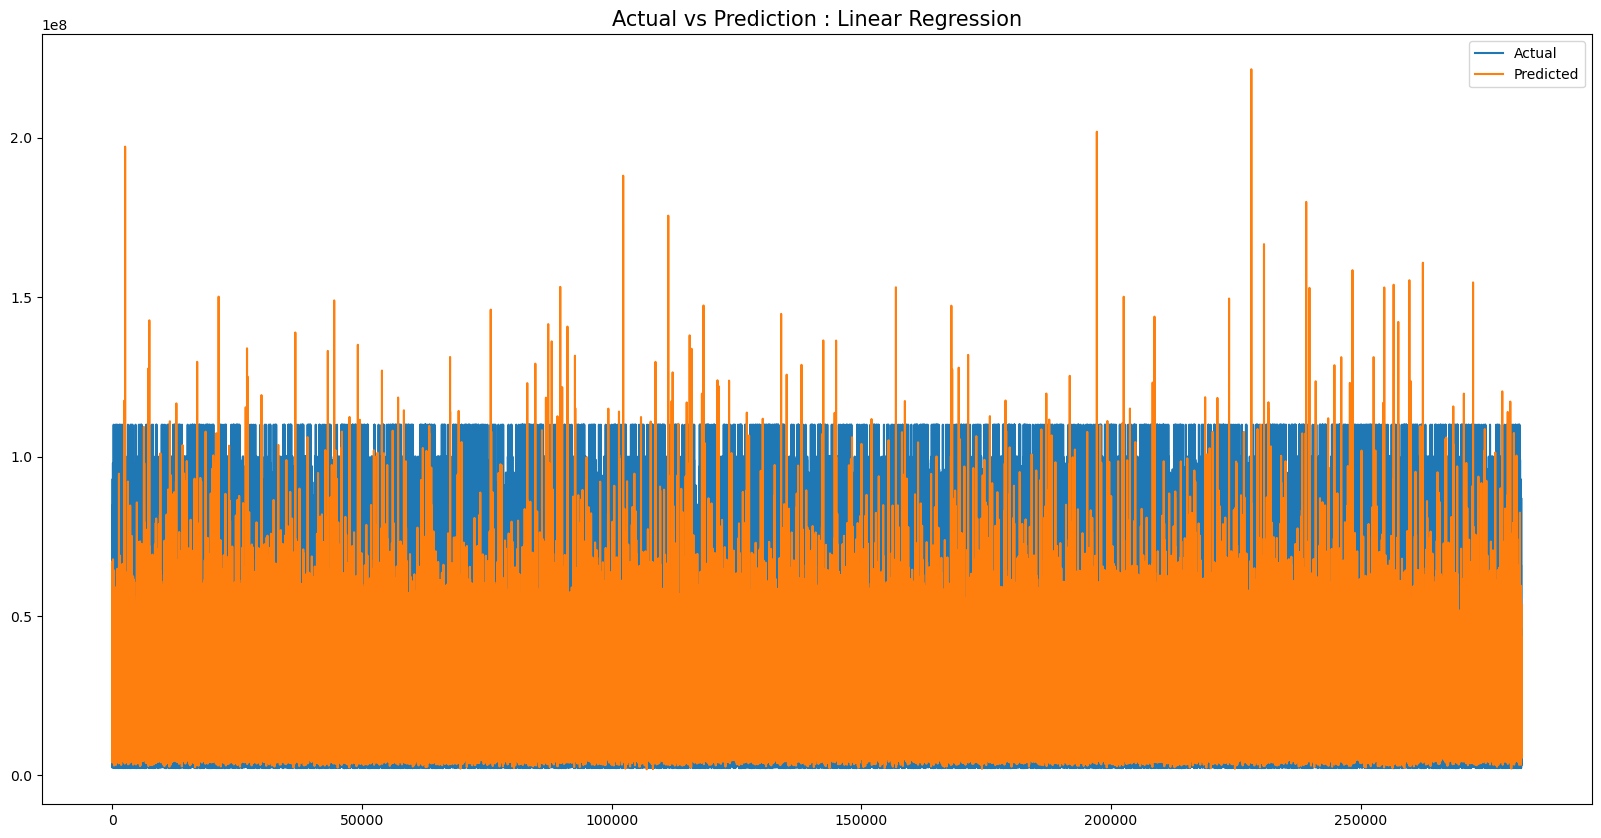

In [81]:
createGraphPrediction(y_testActual, linear_predsActual, 'Actual vs Prediction : Linear Regression', 'LRAvsP')

In [82]:
savePrediction(y_testActual, linear_predsActual, 'LRAvsP')

In [67]:
mlp_reg = MLPRegressor(hidden_layer_sizes=(300,), activation='relu', solver='adam', max_iter = 500)
mlp_reg.fit(x_train,y_train)

MLPRegressor(hidden_layer_sizes=(300,), max_iter=500)

In [68]:
mlp_preds = mlp_reg.predict(x_test)
print(mean_absolute_error(y_test, mlp_preds)*100)

19.187274268632798


In [83]:
mlp_regActual = np.power(10, mlp_preds)

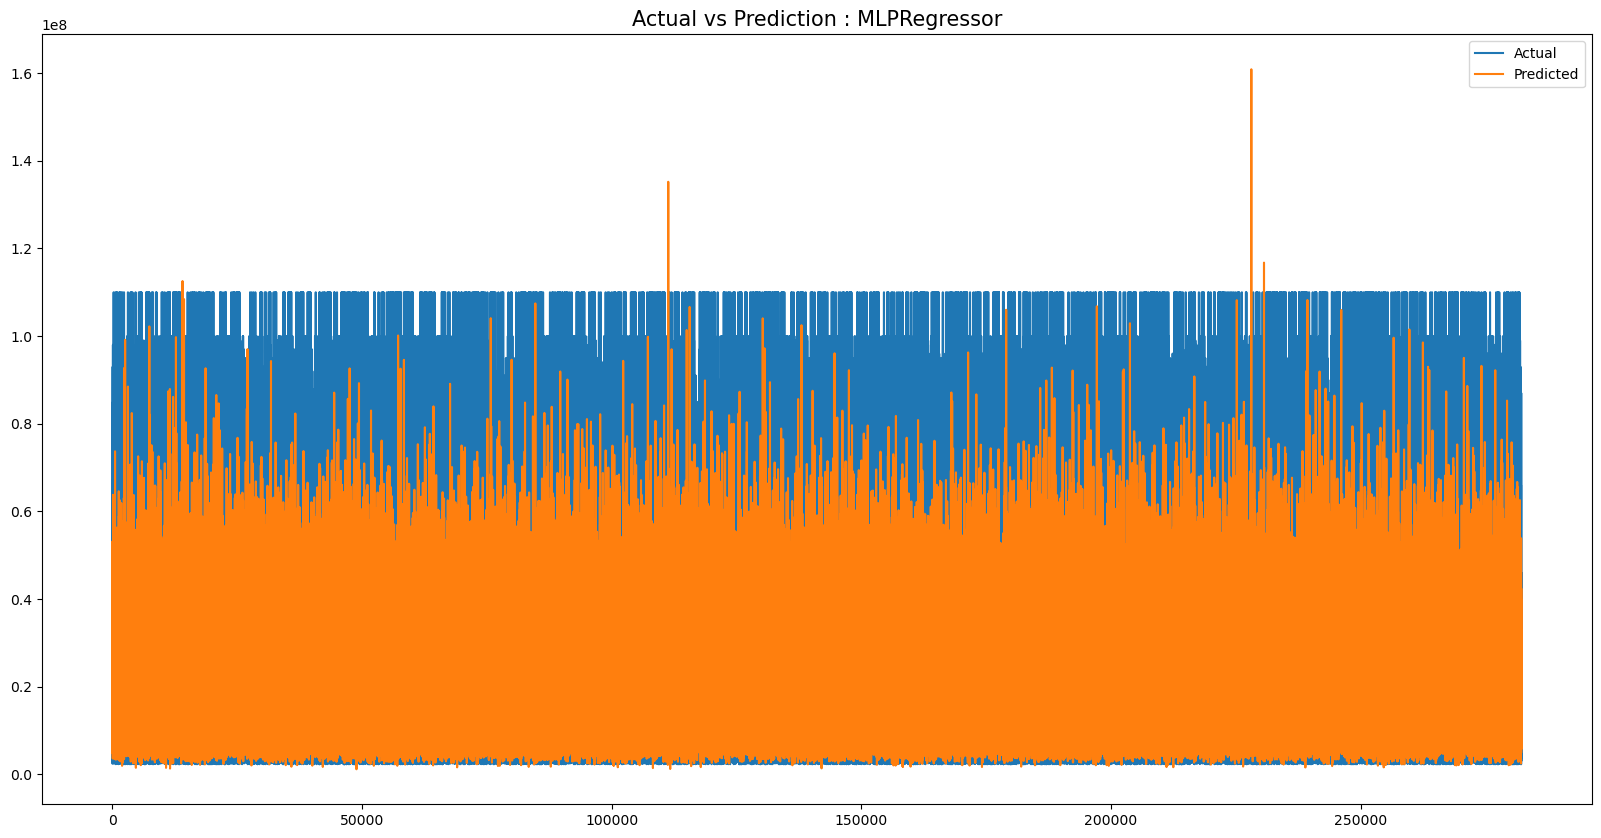

In [84]:
createGraphPrediction(y_testActual, mlp_regActual, 'Actual vs Prediction : MLPRegressor', 'MLPRAvsP')

In [85]:
savePrediction(y_testActual, mlp_regActual, 'MLPRAvsP')

In [73]:
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.05,
                max_depth = 6, alpha = 10, n_estimators = 1000, subsample=0.7)

In [74]:
xgb_reg.fit(x_train, y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, ...)

In [75]:
xgb_preds = xgb_reg.predict(x_test)

In [76]:
print(mean_absolute_error(y_test, xgb_preds)*100)

16.878495330651386


In [86]:
xgb_predsActual = np.power(10, xgb_preds)

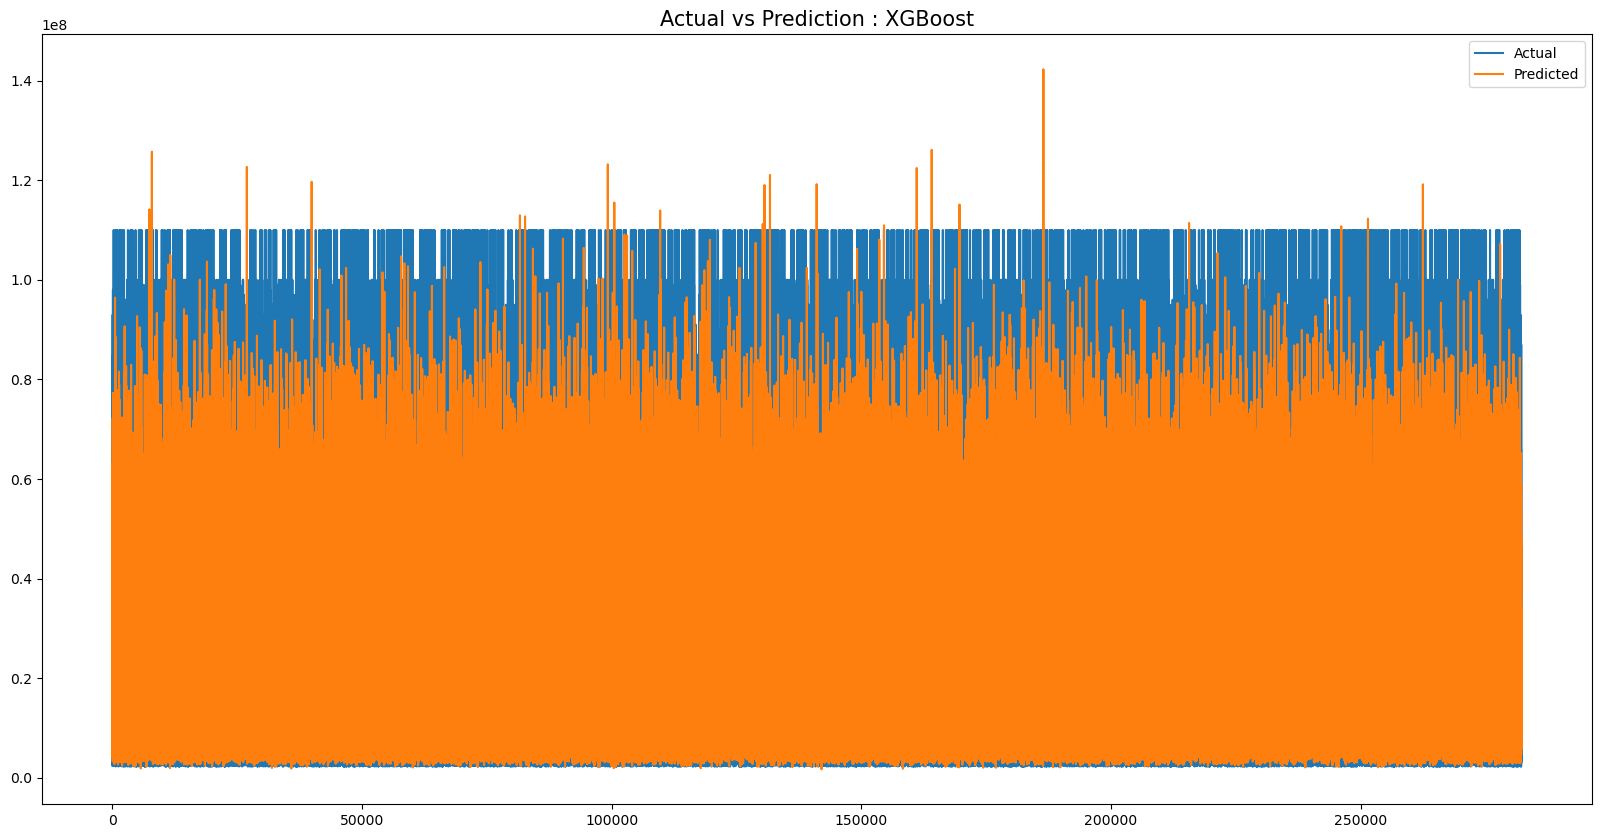

In [87]:
createGraphPrediction(y_test, xgb_predsActual, 'Actual vs Prediction : XGBoost', 'XGBRAvsP')

In [88]:
savePrediction(y_test, xgb_predsActual, 'XGBRAvsP')

In [58]:
rf_reg = RandomForestRegressor(n_estimators= 50,random_state = 1)

In [59]:
rf_reg.fit(x_train, y_train)

RandomForestRegressor(n_estimators=50, random_state=42069)

In [60]:
rfr_preds = rf_reg.predict(x_test)

In [61]:
print(mean_absolute_error(y_test, rfr_preds)*100)

15.895850192298788


In [62]:
rfr_predsActual = np.power(10, rfr_preds)

In [63]:
rf_reg.feature_importances_

array([4.16678083e-01, 9.92566872e-02, 2.44187665e-01, 2.04195819e-03,
       2.28479267e-04, 4.28455965e-04, 3.67427883e-02, 8.90770426e-02,
       3.19119763e-03, 1.98456493e-02, 3.42203257e-02, 1.06466612e-02,
       7.20286433e-03, 7.57417344e-03, 5.42832531e-04, 3.29850395e-03,
       5.27074696e-04, 6.15193078e-03, 1.81576276e-02])

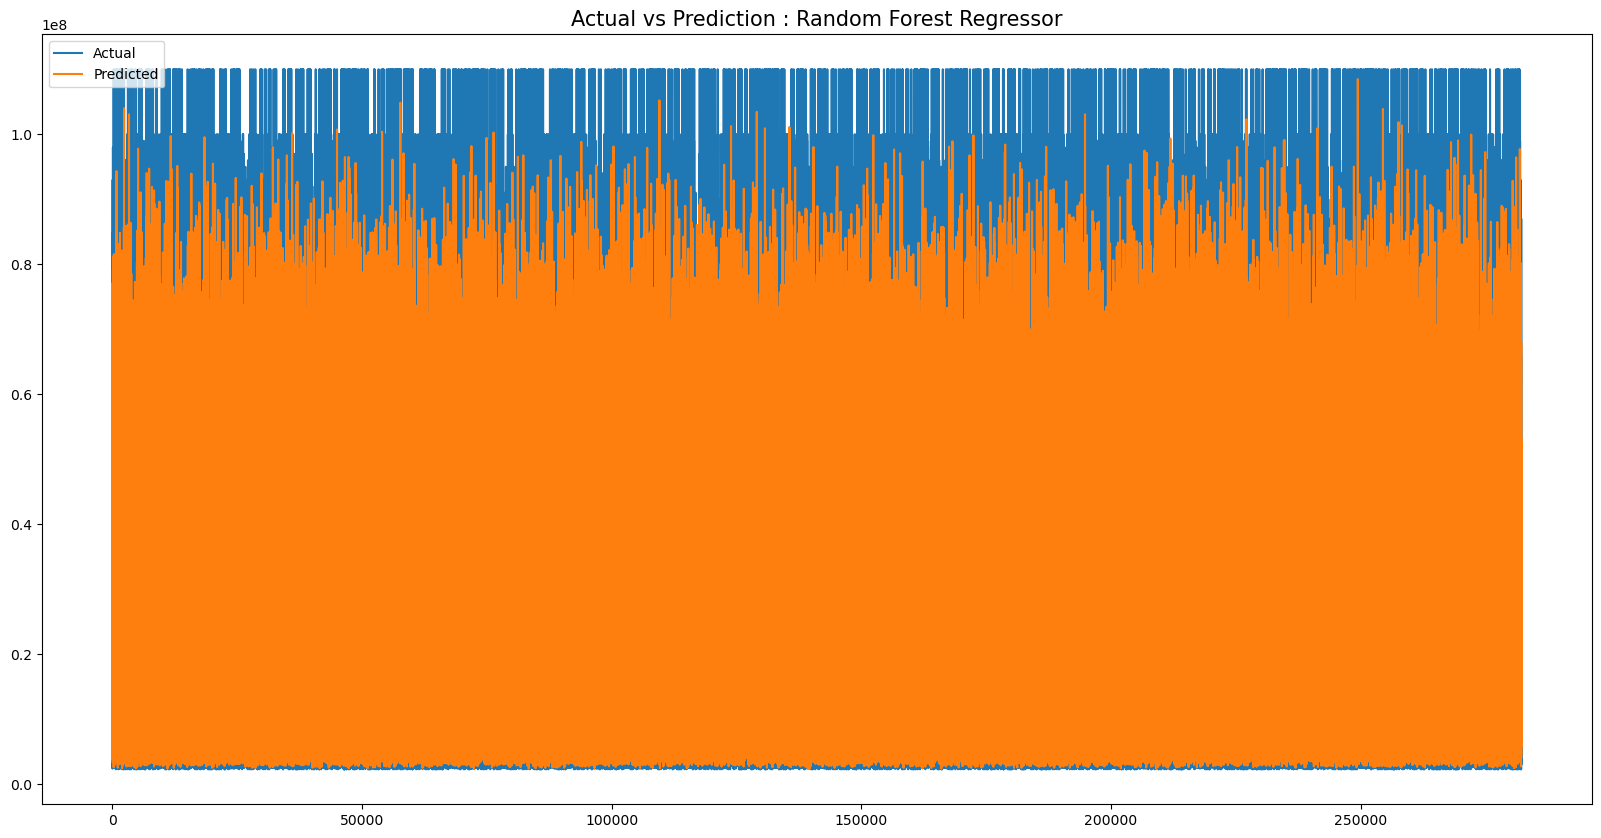

In [64]:
createGraphPrediction(y_testActual, rfr_predsActual, 'Actual vs Prediction : Random Forest Regressor', 'RFRAvsP')

In [65]:
savePrediction(y_testActual, rfr_predsActual, 'RFRAvsP')